### Previos steps

In [14]:
from fastai.vision.all import *
from fastbook import *
from fastai.vision.widgets import *
import seaborn as sns


sns.set()

path = untar_data(URLs.MNIST_SAMPLE)

threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28 * 28)

train_y = tensor([1] * len(threes) + [0] * len(sevens)).unsqueeze(1)

dset = list(zip(train_x, train_y))
x, y = dset[0]

valid_3_tens = torch.stack([tensor(Image.open(o))
                           for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o))
                           for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

print(valid_3_tens.shape, valid_7_tens.shape)

valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28 * 28)
valid_y = tensor([1] * len(valid_3_tens) + [0] *
                 len(valid_7_tens)).unsqueeze(1)

valid_dset = list(zip(valid_x, valid_y))
valid_dl = DataLoader(valid_dset, batch_size=256)

dl = DataLoader(dset, batch_size=256)
xb, yb = first(dl)

dls = DataLoaders(dl, valid_dl)


def init_params(size, std=1.0):
    return (torch.randn(size) * std).requires_grad_()


def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1 - predictions, predictions).mean()


def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()


def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()


torch.Size([1010, 28, 28]) torch.Size([1028, 28, 28])


### The entire definition of a basic neural network

In [15]:
def simple_net(xb):
    res = xb @ w1 + b1
    res = res.max(tensor(0.0))
    res = res @ w2 + b2
    return res


In [16]:
w1 = init_params((28 * 28, 30))
b1 = init_params(30)
w2 = init_params((30, 1))
b2 = init_params(1)


### res.max(tensor(0.0)) is called a rectified linear unit - ReLU

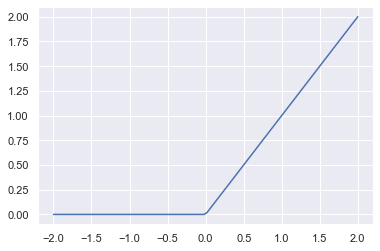

In [17]:
plot_function(F.relu)


The three lines of code that
we have here are known as layers. The first and third are known as linear layers, and
the second line of code is known variously as a nonlinearity, or activation function

nn.Sequential creates a module that will call each of the listed layers or
functions in turn.

Since modules are classes, we have to instantiate them, which is
why you see nn.ReLU in this example

In [18]:
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)


In [19]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)


In [20]:
learn.fit(20, 0.001)


epoch,train_loss,valid_loss,batch_accuracy,time
0,0.349288,0.486137,0.503925,00:00
1,0.323720,0.452792,0.507851,00:00
2,0.289367,0.412086,0.544161,00:00
3,0.243989,0.361829,0.618744,00:00
4,0.187703,0.302167,0.701668,00:00
5,0.120499,0.231918,0.761040,00:00
6,0.040855,0.148248,0.801766,00:00
7,-0.054085,0.047575,0.829244,00:00
8,-0.168079,-0.074440,0.851816,00:00
9,-0.305765,-0.223379,0.864573,00:00


the training process is
recorded in learn.recorder, with the table of output stored in the values
attribute, so we can plot the accuracy over training:

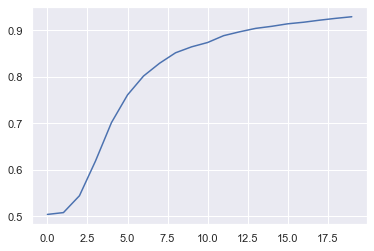

In [21]:
plt.plot(L(learn.recorder.values).itemgot(2))
plt.show()


And we can view the final accuracy

In [22]:
learn.recorder.values[-1][2]


0.92934250831604

### An attempt to complicate the model

I was able to achieve 98% accuracity. It's pretty good!

In [23]:
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 28 * 28),
    nn.ReLU(),
    nn.Linear(28 * 28, 14 * 14),
    nn.Sigmoid(),
    nn.Linear(14 * 14, 1)
)

learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

learn.fit(35, 0.025)


epoch,train_loss,valid_loss,batch_accuracy,time
0,3.544050,0.090160,0.495584,00:00
1,-3.609410,-6.368455,0.505397,00:00
2,-26.818905,-39.890583,0.707556,00:00
3,-59.866520,-91.408768,0.856722,00:00
4,-97.028267,-144.914078,0.907753,00:00
5,-136.158890,-198.186737,0.933759,00:00
6,-176.321365,-250.793304,0.947007,00:00
7,-217.126221,-303.335175,0.951914,00:00
8,-258.305237,-356.724121,0.955839,00:00
9,-299.725281,-410.350922,0.960255,00:00


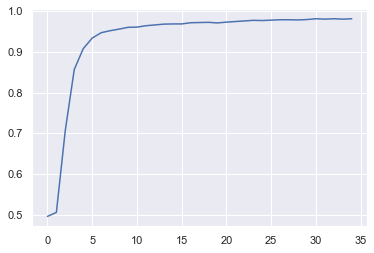

In [24]:
plt.plot(L(learn.recorder.values).itemgot(2))
plt.show()


In [25]:
learn.recorder.values[-1][2]


0.981354296207428

NN that consists of 18 nonlinear layers

In [26]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


d:\Projects\PythonProjects\DLS-Rush\venv\lib\site-packages\fastai\vision\learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,time
0,0.152172,0.040525,0.992640,00:32
